# MRI brain tumor detection

Kaggle dataset: https://www.kaggle.com/datasets/navoneel/brain-mri-images-for-brain-tumor-detection

In [1]:
import numpy as np
import torch
import glob
from torch.utils.data import Dataset, DataLoader, ConcatDataset
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score
import cv2

## Reading data

In [2]:
tumor = []
healthy = []
path = './brain_tumor_dataset/yes/*.jpg'
path_healthy = './brain_tumor_dataset/no/*.jpg'

In [3]:
for file in glob.iglob(path):
    img = cv2.imread(file)
    img = cv2.resize(img, (128,128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    tumor.append(img)

In [4]:
for file in glob.iglob(path_healthy):
    img = cv2.imread(file)
    img = cv2.resize(img, (128,128))
    b, g, r = cv2.split(img)
    img = cv2.merge([r, g, b])
    healthy.append(img)

In [5]:
healthy = np.array(healthy)
tumor = np.array(tumor)
all_cases = np.concatenate((healthy, tumor))

## Visualizing images

In [6]:
def random_images(arr1, arr2, num):

    # Ensure num doesn't exceed the available images in either array
    num = min(num, len(arr1), len(arr2))

    # Select 'num' random images from 'arr1' and 'arr2'
    indices1 = np.random.choice(len(arr1), num, replace=False)
    indices2 = np.random.choice(len(arr2), num, replace=False)
    selected_images1 = arr1[indices1]
    selected_images2 = arr2[indices2]

    # Define figure size dynamically based on 'num'
    plt.figure(figsize=(num * 2, 5))

    # Plot first row (arr1 images)
    for i in range(num):
        plt.subplot(2, num, i + 1)
        plt.imshow(selected_images1[i])
        plt.axis("off")
        plt.title(f"Arr1 Img {i+1}")

    # Plot second row (arr2 images)
    for i in range(num):
        plt.subplot(2, num, num + i + 1)
        plt.imshow(selected_images2[i])
        plt.axis("off")
        plt.title(f"Arr2 Img {i+1}")

    plt.show()

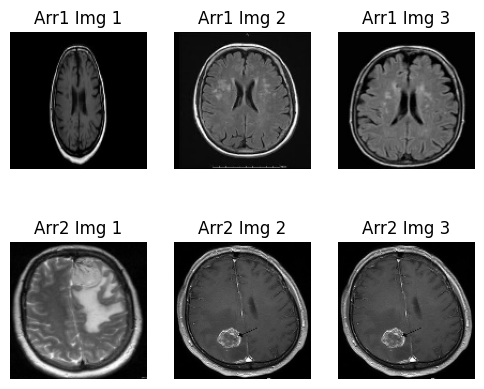

In [7]:
random_images(healthy, tumor, 3)

In [8]:
class MRI(Dataset):
    def __init__(self):
        
        tumor = []
        healthy = []
        # cv2 - It reads in BGR format by default
        for f in glob.iglob("./brain_tumor_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) # I can add this later in the boot-camp for more adventure
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) # otherwise the shape will be (h,w,#channels)
            tumor.append(img)

        for f in glob.iglob("./brain_tumor_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        # our images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)
        
        # our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)
        
        # Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))
        
    def __len__(self):
        return self.images.shape[0]
    
    def __getitem__(self, index):
        
        sample = {'image': self.images[index], 'label':self.labels[index]}
        
        return sample
    
    def normalize(self):
        self.images = self.images/255.0

In [9]:
mri_dataset = MRI()
mri_dataset.normalize()

In [10]:
# Check the length of the dataset
print(len(mri_dataset))

245


## Dataloader

In [11]:
# One way of iterating
names={0:'Healthy', 1:'Tumor'}
dataloader = DataLoader(mri_dataset, shuffle=True)
for i, sample in enumerate(dataloader):
    img = sample['image'].squeeze()
    img = img.reshape((img.shape[1], img.shape[2], img.shape[0]))
    plt.title(names[sample['label'].item()])
    plt.imshow(img)
    plt.show()
    if i == 2:
        break

## NN model

In [12]:
import torch.nn as nn
import torch.nn.functional as F

class CNN(nn.Module):
    def __init__(self):
        super(CNN,self).__init__()
        self.cnn_model = nn.Sequential(
        nn.Conv2d(in_channels=3, out_channels=6, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5),
        nn.Conv2d(in_channels=6, out_channels=16, kernel_size=5),
        nn.Tanh(),
        nn.AvgPool2d(kernel_size=2, stride=5))
        
        self.fc_model = nn.Sequential(
        nn.Linear(in_features=256, out_features=120),
        nn.Tanh(),
        nn.Linear(in_features=120, out_features=84),
        nn.Tanh(),
        nn.Linear(in_features=84, out_features=1))
        
    def forward(self, x):
        x = self.cnn_model(x)
        x = x.view(x.size(0), -1)
        x = self.fc_model(x)
        x = F.sigmoid(x)
        
        return x

## Check if GPU is available

In [13]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# creating a CPU tensor
cpu_tensor = torch.rand(10).to(device)
# moving same tensor to GPU
gpu_tensor = cpu_tensor.to(device)

print(cpu_tensor, cpu_tensor.dtype, type(cpu_tensor), cpu_tensor.type())
print(gpu_tensor, gpu_tensor.dtype, type(gpu_tensor), gpu_tensor.type())

print(cpu_tensor*gpu_tensor)

tensor([0.7188, 0.9568, 0.3726, 0.2899, 0.1422, 0.2518, 0.8064, 0.6836, 0.0897,
        0.9572]) torch.float32 <class 'torch.Tensor'> torch.FloatTensor
tensor([0.7188, 0.9568, 0.3726, 0.2899, 0.1422, 0.2518, 0.8064, 0.6836, 0.0897,
        0.9572]) torch.float32 <class 'torch.Tensor'> torch.FloatTensor
tensor([0.5167, 0.9155, 0.1388, 0.0841, 0.0202, 0.0634, 0.6503, 0.4673, 0.0080,
        0.9162])


In [14]:
import sys
print(sys.prefix)

C:\Users\batvi\AppData\Local\Programs\Python\Python312


## Evaluation of initialized NN

In [15]:
mri_dataset = MRI()
mri_dataset.normalize()
model = CNN().to(device)

In [16]:
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [17]:
model.eval()
outputs = []
y_true = []
with torch.no_grad():
    for D in dataloader:
        image = D['image'].to(device)
        label = D['label'].to(device)

        y_hat = model(image)

        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())

In [18]:
outputs = np.concatenate( outputs, axis=0 ).squeeze()
y_true = np.concatenate( y_true, axis=0 ).squeeze()

In [19]:
def threshold(scores,threshold=0.50, minimum=0, maximum = 1.0):
    x = np.array(list(scores))
    x[x >= threshold] = maximum
    x[x < threshold] = minimum
    return x

In [20]:
accuracy_score(y_true, threshold(outputs))

0.37142857142857144

## Display confusion matrix

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

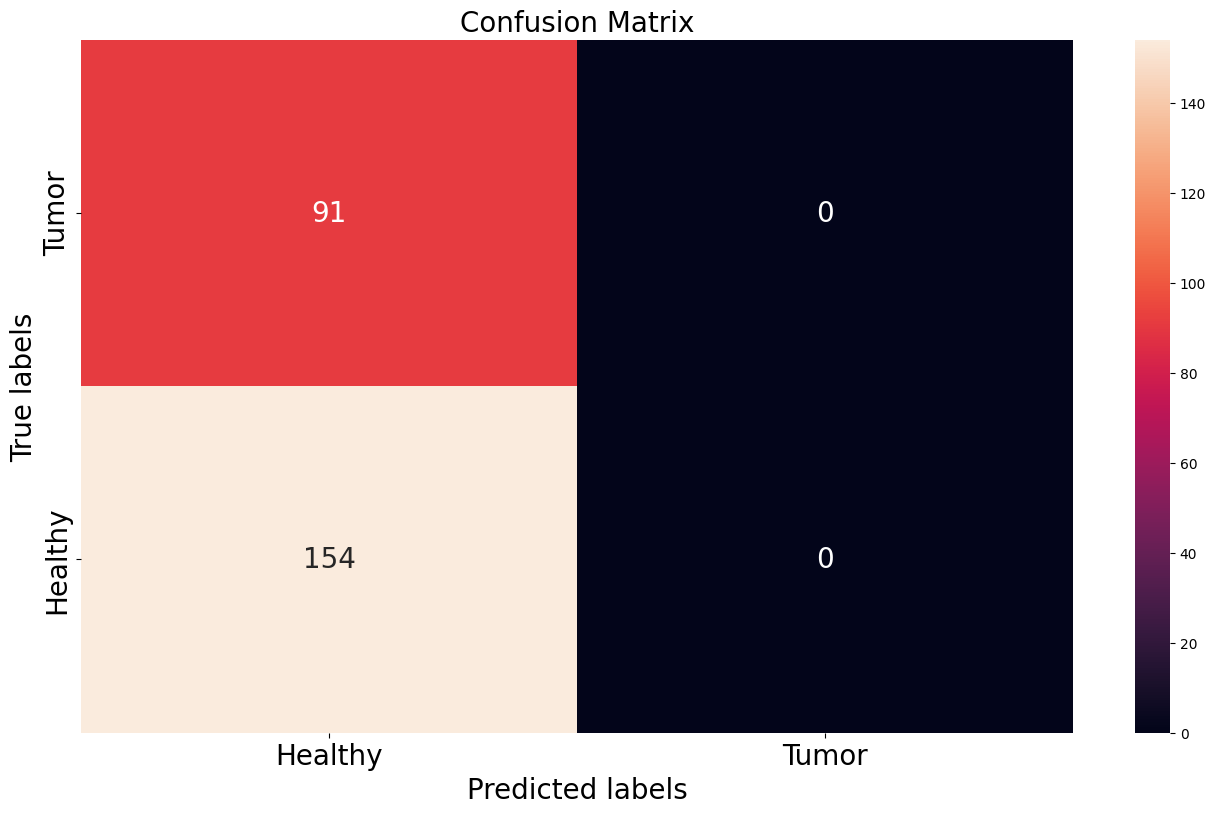

In [21]:
# a better confusion matrix
import seaborn as sns

plt.figure(figsize=(16,9))
cm = confusion_matrix(y_true, threshold(outputs))
ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax, annot_kws={"size": 20})

# labels, title and ticks
ax.set_xlabel('Predicted labels', fontsize=20)
ax.set_ylabel('True labels', fontsize=20) 
ax.set_title('Confusion Matrix', fontsize=20)
ax.xaxis.set_ticklabels(['Healthy','Tumor'], fontsize=20)
ax.yaxis.set_ticklabels(['Tumor','Healthy'], fontsize=20)

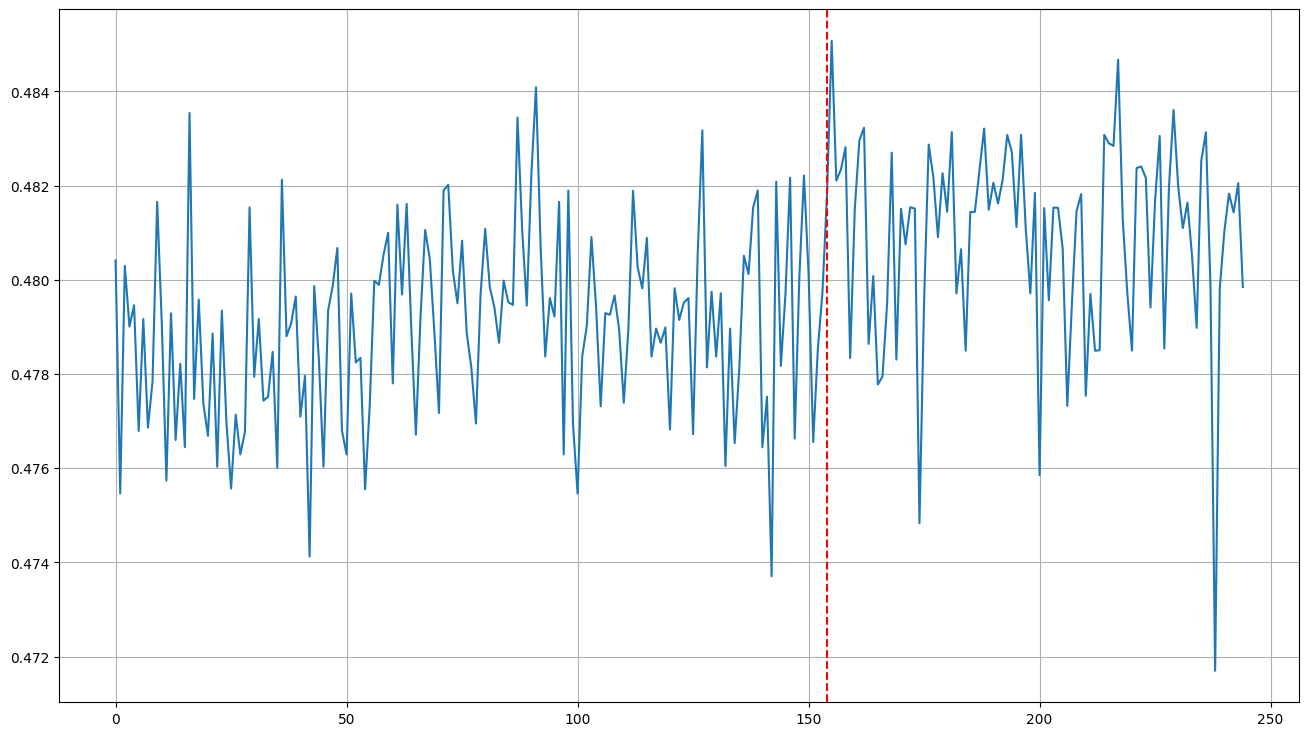

In [22]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

## Train the model

In [23]:
eta = 0.0001
EPOCH = 400
optimizer = torch.optim.Adam(model.parameters(), lr=eta)
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
model.train()

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [24]:
for epoch in range(1, EPOCH):
    losses = []
    for D in dataloader:
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        y_hat = model(data)
        # define loss function
        error = nn.BCELoss() 
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        losses.append(loss.item())
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tLoss: {:.6f}'.format(epoch+1, np.mean(losses)))

Train Epoch: 10	Loss: 0.621841
Train Epoch: 20	Loss: 0.588858
Train Epoch: 30	Loss: 0.539632
Train Epoch: 40	Loss: 0.509155
Train Epoch: 50	Loss: 0.492691
Train Epoch: 60	Loss: 0.476549
Train Epoch: 70	Loss: 0.453319
Train Epoch: 80	Loss: 0.439914
Train Epoch: 90	Loss: 0.428885
Train Epoch: 100	Loss: 0.419458
Train Epoch: 110	Loss: 0.405663
Train Epoch: 120	Loss: 0.380642
Train Epoch: 130	Loss: 0.355885
Train Epoch: 140	Loss: 0.346580
Train Epoch: 150	Loss: 0.326412
Train Epoch: 160	Loss: 0.302378
Train Epoch: 170	Loss: 0.284910
Train Epoch: 180	Loss: 0.259394
Train Epoch: 190	Loss: 0.240069
Train Epoch: 200	Loss: 0.227688
Train Epoch: 210	Loss: 0.191648
Train Epoch: 220	Loss: 0.167289
Train Epoch: 230	Loss: 0.156071
Train Epoch: 240	Loss: 0.134437
Train Epoch: 250	Loss: 0.116329
Train Epoch: 260	Loss: 0.100558
Train Epoch: 270	Loss: 0.086340
Train Epoch: 280	Loss: 0.089232
Train Epoch: 290	Loss: 0.060244
Train Epoch: 300	Loss: 0.049152
Train Epoch: 310	Loss: 0.041165
Train Epoch: 320	

## Evaluate the trained model

In [25]:
model.eval()
dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)
outputs=[]
y_true = []
with torch.no_grad():
    for D in dataloader:
        image =  D['image'].to(device)
        label = D['label'].to(device)
        
        y_hat = model(image)
        
        outputs.append(y_hat.cpu().detach().numpy())
        y_true.append(label.cpu().detach().numpy())
        
outputs = np.concatenate( outputs, axis=0 )
y_true = np.concatenate( y_true, axis=0 )

In [26]:
accuracy_score(y_true, threshold(outputs))

1.0

[Text(0, 0.5, 'Tumor'), Text(0, 1.5, 'Healthy')]

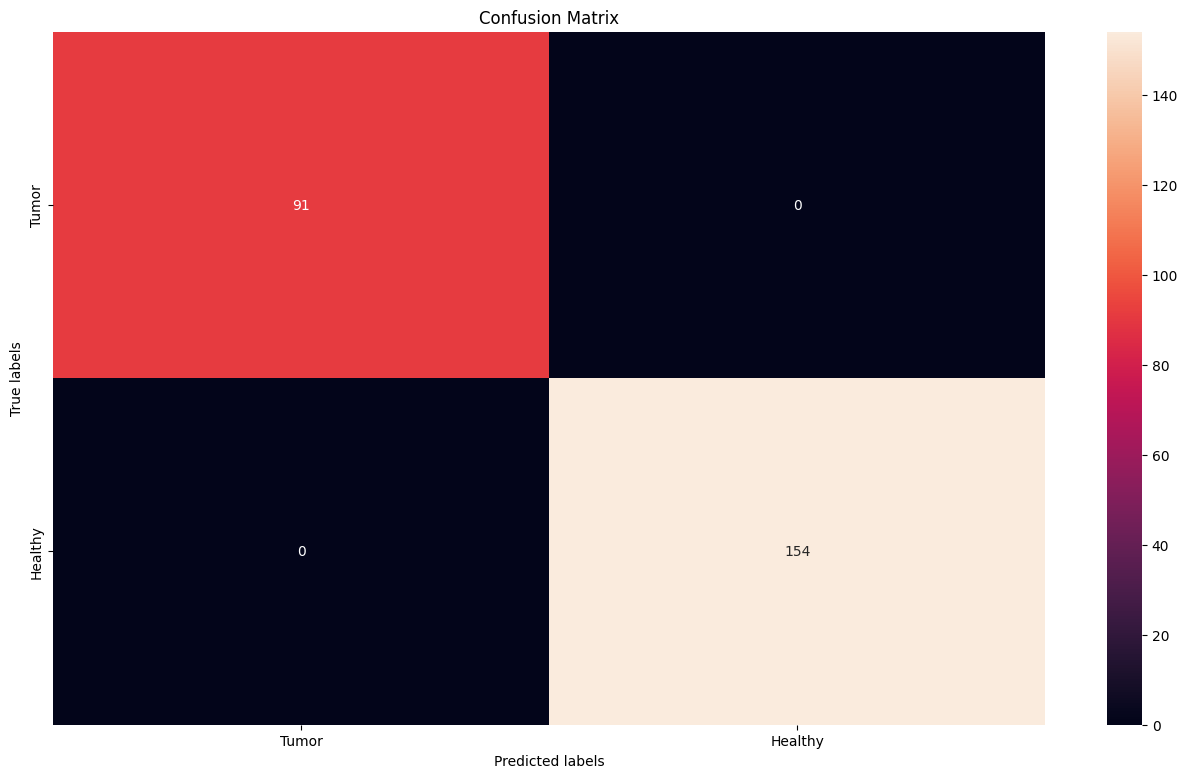

In [27]:
cm = confusion_matrix(y_true, threshold(outputs))
plt.figure(figsize=(16,9))

ax= plt.subplot()
sns.heatmap(cm, annot=True, fmt='g', ax=ax);  #annot=True to annotate cells, ftm='g' to disable scientific notation

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix'); 
ax.xaxis.set_ticklabels(['Tumor','Healthy'])
ax.yaxis.set_ticklabels(['Tumor','Healthy'])

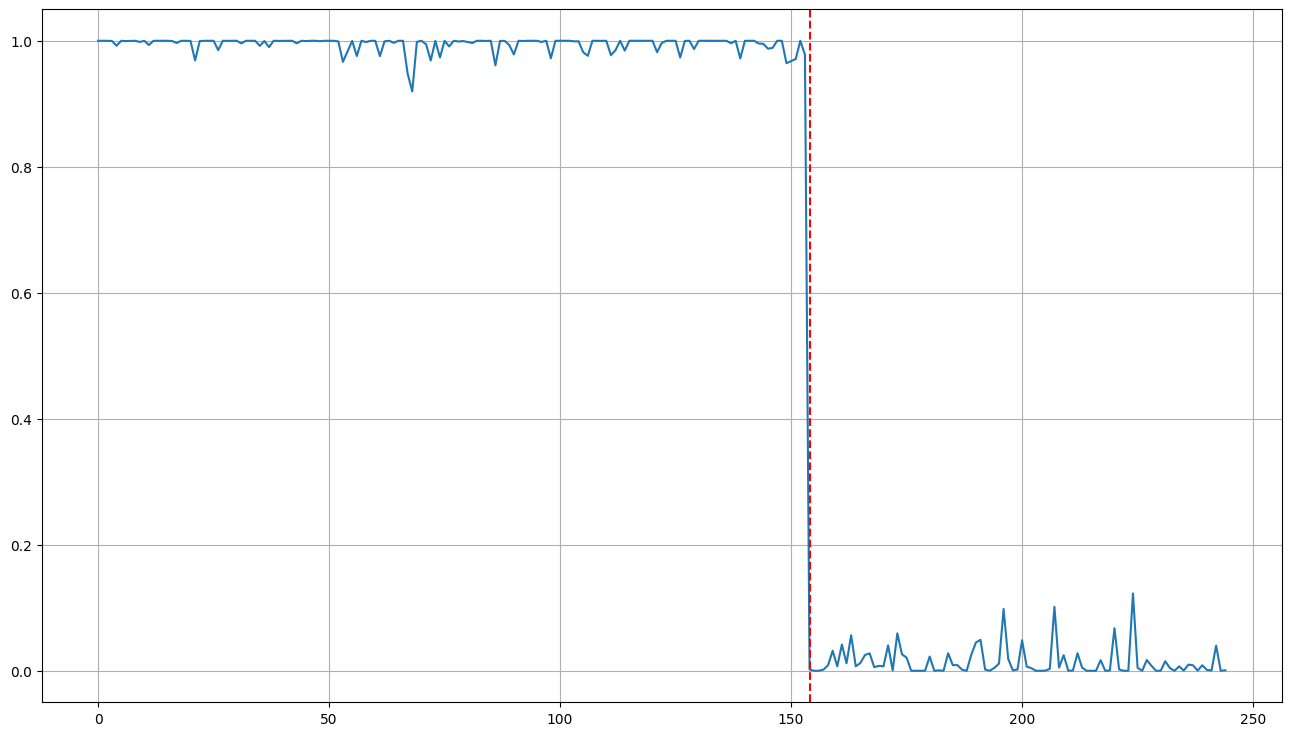

In [28]:
plt.figure(figsize=(16,9))
plt.plot(outputs)
plt.axvline(x=len(tumor), color='r', linestyle='--')
plt.grid()

## Visualize the feature maps of the convolutional filters

In [29]:
model

CNN(
  (cnn_model): Sequential(
    (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
    (1): Tanh()
    (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
    (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
    (4): Tanh()
    (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
  )
  (fc_model): Sequential(
    (0): Linear(in_features=256, out_features=120, bias=True)
    (1): Tanh()
    (2): Linear(in_features=120, out_features=84, bias=True)
    (3): Tanh()
    (4): Linear(in_features=84, out_features=1, bias=True)
  )
)

In [30]:
no_of_layers = 0
conv_layers = []

In [31]:
model_children = list(model.children())
model_children

[Sequential(
   (0): Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1))
   (1): Tanh()
   (2): AvgPool2d(kernel_size=2, stride=5, padding=0)
   (3): Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))
   (4): Tanh()
   (5): AvgPool2d(kernel_size=2, stride=5, padding=0)
 ),
 Sequential(
   (0): Linear(in_features=256, out_features=120, bias=True)
   (1): Tanh()
   (2): Linear(in_features=120, out_features=84, bias=True)
   (3): Tanh()
   (4): Linear(in_features=84, out_features=1, bias=True)
 )]

In [32]:
for child in model_children:
    if type(child) == nn.Sequential:
        for layer in child.children():
            if type(layer) == nn.Conv2d:
                no_of_layers += 1
                conv_layers.append(layer)

In [33]:
conv_layers

[Conv2d(3, 6, kernel_size=(5, 5), stride=(1, 1)),
 Conv2d(6, 16, kernel_size=(5, 5), stride=(1, 1))]

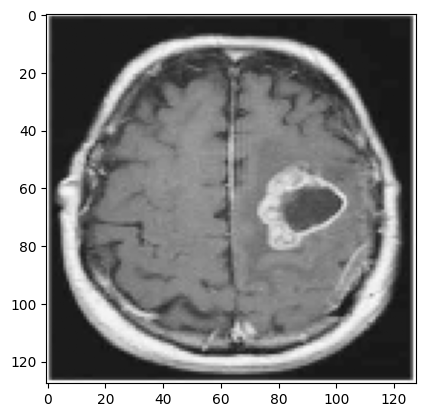

In [34]:
img = mri_dataset[100]['image']
plt.imshow(img.reshape(128,128,3))

In [35]:
img = torch.from_numpy(img).to(device)

In [36]:
img.shape

torch.Size([3, 128, 128])

In [37]:
img = img.unsqueeze(0)
img.shape

torch.Size([1, 3, 128, 128])

In [38]:
results = [conv_layers[0](img)]
for i in range(1, len(conv_layers)):
    results.append(conv_layers[i](results[-1]))
outputs = results

Layer  1


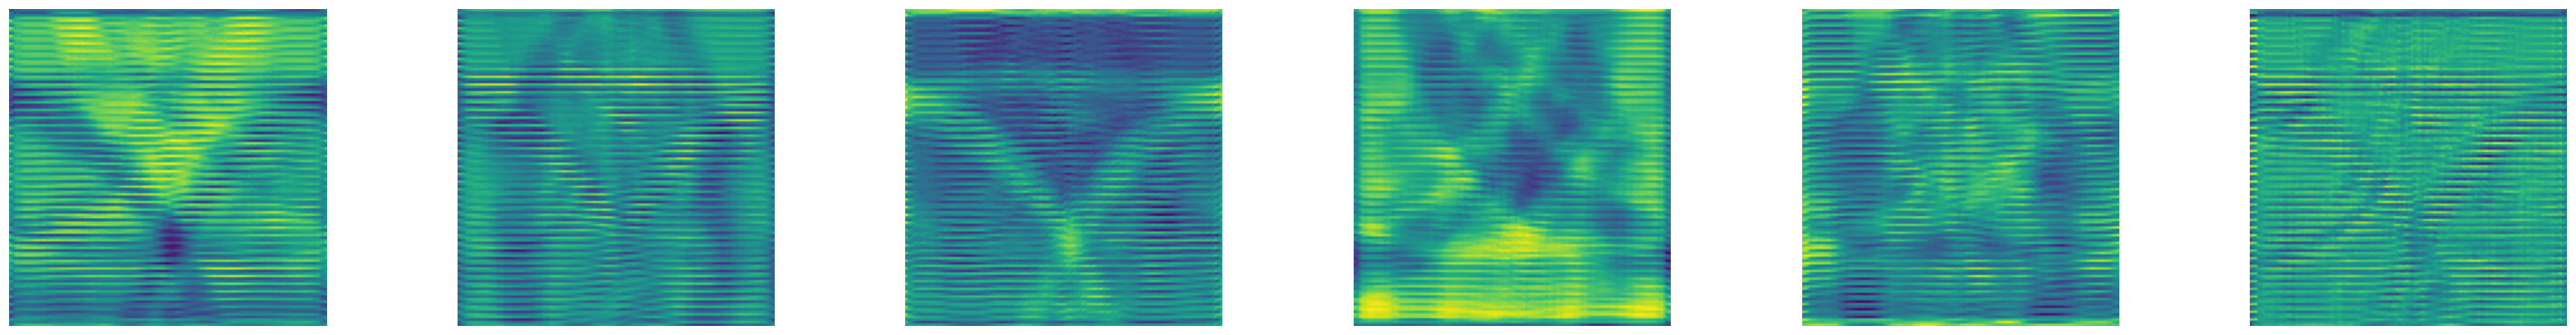

Layer  2


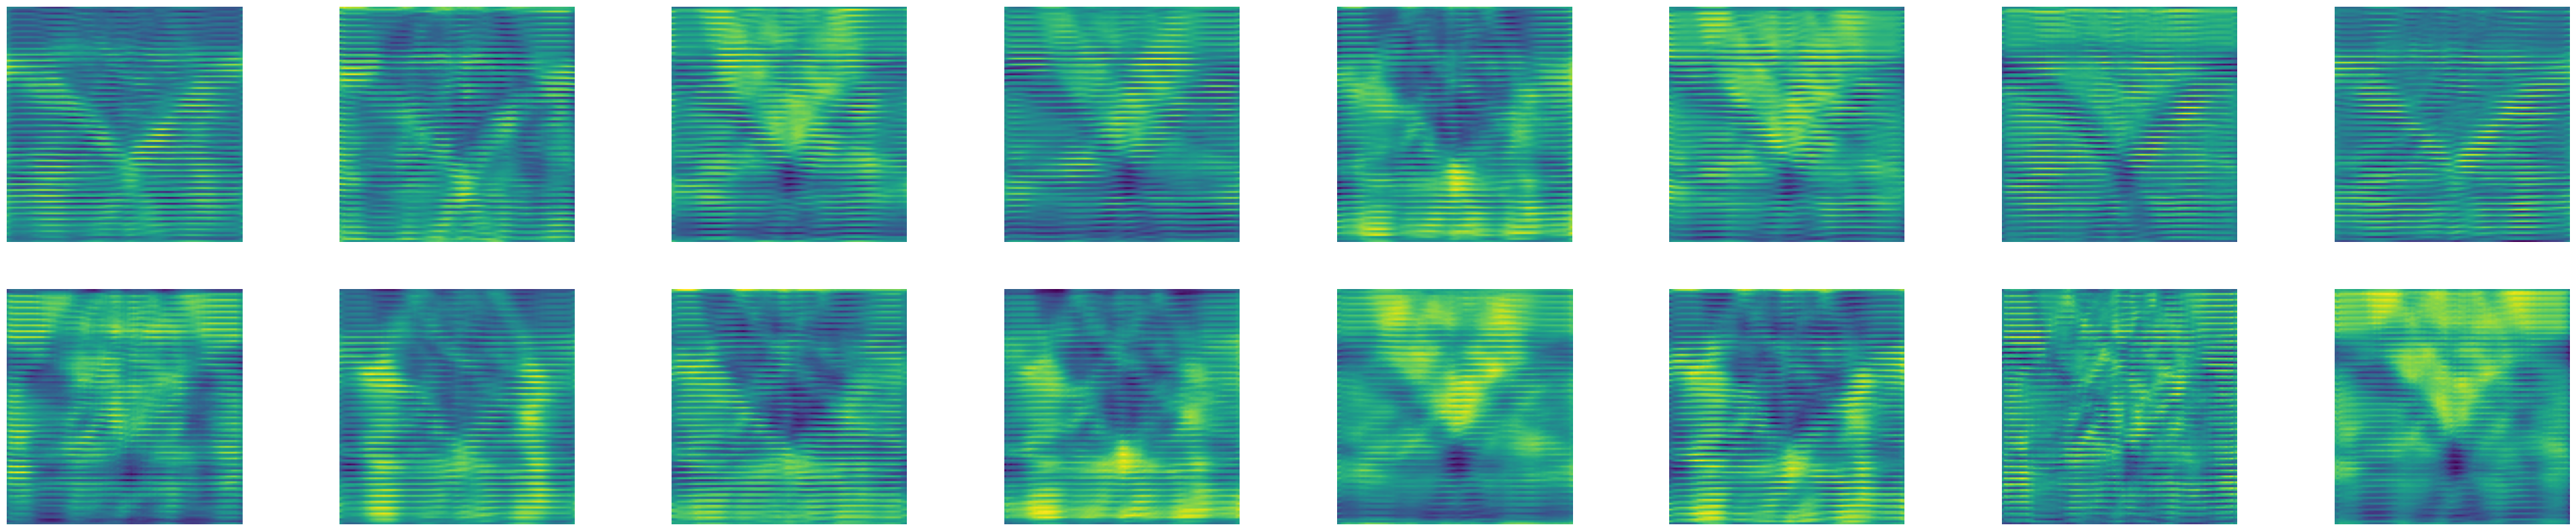

In [39]:
for num_layer in range(len(outputs)):
    plt.figure(figsize=(50, 10))
    layer_viz = outputs[num_layer].squeeze()
    print("Layer ",num_layer+1)
    for i, f in enumerate(layer_viz):
        plt.subplot(2, 8, i + 1)
        plt.imshow(f.detach().cpu().numpy())
        plt.axis("off")
    plt.show()
    plt.close()

## Validation set to solve overfitting

In [40]:
# Import train/test split function from sklearn
from sklearn.model_selection import train_test_split

In [41]:
class MRI(Dataset):
    
    def __init__(self):
        
        # Variables to hold the Training data and Validation data
        self.X_train, self.y_train, self.X_val, self.y_val = None, None, None, None
        
        # A variable to determine if we are interested in retrieving the training OR the validation data
        self.mode = 'train'
        
        tumor = []
        healthy = []
        # cv2 - It reads in BGR format by default
        for f in glob.iglob("./brain_tumor_dataset/yes/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) # I can add this later in the boot-camp for more adventure
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1])) # otherwise the shape will be (h,w,#channels)
            tumor.append(img)

        for f in glob.iglob("./brain_tumor_dataset/no/*.jpg"):
            img = cv2.imread(f)
            img = cv2.resize(img,(128,128)) 
            b, g, r = cv2.split(img)
            img = cv2.merge([r,g,b])
            img = img.reshape((img.shape[2],img.shape[0],img.shape[1]))
            healthy.append(img)

        # our images
        tumor = np.array(tumor,dtype=np.float32)
        healthy = np.array(healthy,dtype=np.float32)
        
        # our labels
        tumor_label = np.ones(tumor.shape[0], dtype=np.float32)
        healthy_label = np.zeros(healthy.shape[0], dtype=np.float32)
        
        # Concatenates
        self.images = np.concatenate((tumor, healthy), axis=0)
        self.labels = np.concatenate((tumor_label, healthy_label))
    
    # Define a function that would separate the data into Training and Validation sets
    def train_val_split(self):
        self.X_train, self.X_val, self.y_train, self.y_val = \
        train_test_split(self.images, self.labels, test_size=0.20, random_state=42)
        
    def __len__(self):
        # Use self.mode to deetrmine whether train or val data is of interest
        if self.mode == 'train':
            return self.X_train.shape[0]
        elif self.mode == 'val':
            return self.X_val.shape[0]
    
    def __getitem__(self, idx):
        # Use self.mode to deetrmine whether train or val data is of interest
        if self.mode== 'train':
            sample = {'image': self.X_train[idx], 'label': self.y_train[idx]}
        
        elif self.mode== 'val':
            sample = {'image': self.X_val[idx], 'label': self.y_val[idx]}
        
        return sample
    
    def normalize(self):
        self.images = self.images/255.0

In [42]:
mri_dataset = MRI()
mri_dataset.normalize()
mri_dataset.train_val_split()

In [43]:
train_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=True)
val_dataloader = DataLoader(mri_dataset, batch_size=32, shuffle=False)

In [44]:
device = torch.device("cpu")
model = CNN().to(device)

In [45]:
eta=0.0001
optimizer = torch.optim.Adam(model.parameters(), lr=eta)

In [46]:
# keep track of epoch losses
epoch_train_loss = []
epoch_val_loss = []

In [47]:
for epoch in range(1,600):
    train_losses = []
    # train for the current epoch
    model.train()
    mri_dataset.mode = 'train'
    for D in train_dataloader:
        # Train the model
        optimizer.zero_grad()
        data = D['image'].to(device)
        label = D['label'].to(device)
        
        y_hat = model(data)
        error = nn.BCELoss()
        loss = torch.sum(error(y_hat.squeeze(), label))
        loss.backward()
        optimizer.step()
        train_losses.append(loss.item())
    
    epoch_train_loss.append(np.mean(train_losses))
    
    # validate for the current epoch
    val_losses = []
    model.eval()
    
    mri_dataset.mode = 'val'
    
    with torch.no_grad():
        for D in val_dataloader:            
            data = D['image'].to(device)
            label = D['label'].to(device)
            y_hat = model(data)
            error = nn.BCELoss()
            loss = torch.sum(error(y_hat.squeeze(), label))
            val_losses.append(loss.item())
    
    epoch_val_loss.append(np.mean(val_losses))
    
    if (epoch+1) % 10 == 0:
        print('Train Epoch: {}\tTrain Loss: {:.6f}\tVal Loss: {:.6f}'.format(epoch+1, np.mean(train_losses),np.mean(val_losses)))

Train Epoch: 10	Train Loss: 0.614238	Val Loss: 0.602846
Train Epoch: 20	Train Loss: 0.661576	Val Loss: 0.591040
Train Epoch: 30	Train Loss: 0.602234	Val Loss: 0.577468
Train Epoch: 40	Train Loss: 0.593317	Val Loss: 0.572299
Train Epoch: 50	Train Loss: 0.578548	Val Loss: 0.551487
Train Epoch: 60	Train Loss: 0.553107	Val Loss: 0.544498
Train Epoch: 70	Train Loss: 0.498907	Val Loss: 0.526073
Train Epoch: 80	Train Loss: 0.460546	Val Loss: 0.530590
Train Epoch: 90	Train Loss: 0.488771	Val Loss: 0.552349
Train Epoch: 100	Train Loss: 0.456284	Val Loss: 0.564070
Train Epoch: 110	Train Loss: 0.423902	Val Loss: 0.565204
Train Epoch: 120	Train Loss: 0.406836	Val Loss: 0.578946
Train Epoch: 130	Train Loss: 0.441289	Val Loss: 0.598010
Train Epoch: 140	Train Loss: 0.463953	Val Loss: 0.642239
Train Epoch: 150	Train Loss: 0.375609	Val Loss: 0.612656
Train Epoch: 160	Train Loss: 0.404507	Val Loss: 0.616671
Train Epoch: 170	Train Loss: 0.427047	Val Loss: 0.644408
Train Epoch: 180	Train Loss: 0.431710	Va

Text(0, 0.5, 'Loss')

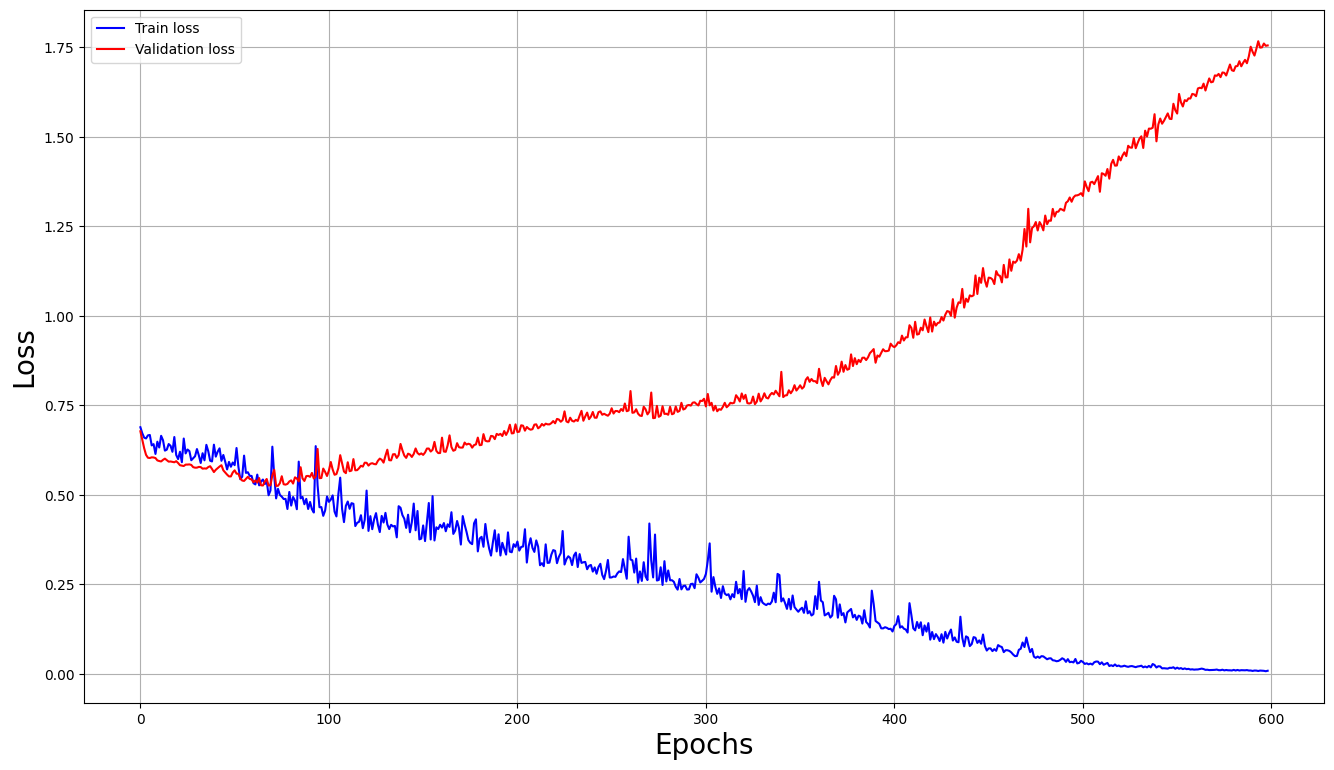

In [48]:
plt.figure(figsize=(16,9))
plt.plot(epoch_train_loss, c='b', label='Train loss')
plt.plot(epoch_val_loss, c='r', label = 'Validation loss')
plt.legend()
plt.grid()
plt.xlabel('Epochs', fontsize=20)
plt.ylabel('Loss', fontsize=20)